# How to use fuvpy

fuvpy is a collection of functions to analyse and visualize auroral images generated with fuview3 (or xvis).
The images are stored in xarray.Dataset variables, so xarray must be installed.  
This is very much a work in progress, so the code might change considerably in the semi-near future.

Images are loades as follows:

In [1]:
import fuvpy as fuv
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
from polplot import pp

# %matplotlib notebook

path = '../data/wicFiles/'
wicfiles = glob.glob(path + '*.idl')
wic = fuv.readFUVimage(wicfiles)
wic


Bad key "text.kerning_factor" on line 4 in
/Users/aohma/anaconda3/envs/lompe-env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


<xarray.Dataset>
Dimensions:     (date: 15, row: 256, col: 256)
Coordinates:
  * date        (date) datetime64[ns] 2000-08-28T09:28:42 ... 2000-08-28T09:5...
Dimensions without coordinates: row, col
Data variables:
    img         (date, row, col) float32 684.7 723.2 689.4 ... -485.1 -485.1
    mlat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlt         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    dza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    sza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    hemisphere  (date) <U5 'north' 'north' 'north' ... 'north' 'north' 'north'
    id          <U3 'WIC'
    bad         (row, col) bool False False False False ... False False False

Two different ways to select and plot the images

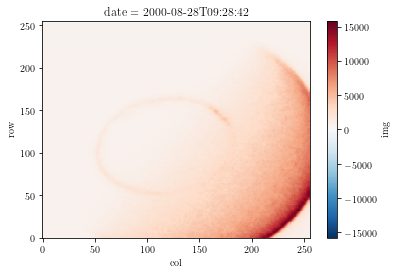

In [2]:
wic.sel(date='2000-08-28 09:28:42')['img'].plot()

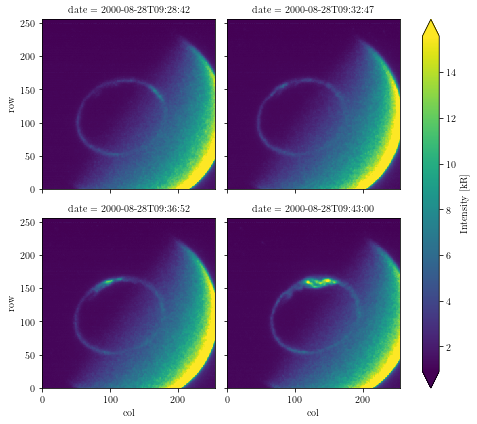

In [3]:
wic = fuv.getFUVrayleigh(wic,'img')
wic.isel(date=[0,2,4,7])['imgR'].plot(x='col', y='row', col='date', col_wrap=2,robust=True)

In the same way we can visualize for instance the viewing anlge for these images:

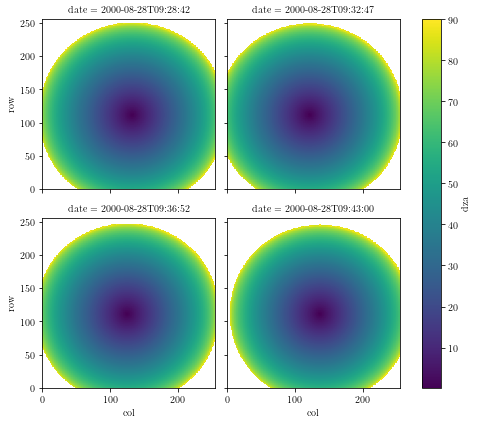

In [4]:
wic.isel(date=[0,2,4,7])['dza'].plot(x='col', y='row', col='date', col_wrap=2)

Note how the name and units of the variables appear automatically in the figures. They are added to each variable, and can be accessed (and assigned) using wic['nameofvariable'].attrs.

A routine to plot the images in polar coordinates has been added to the Polarsubplot class.
Here is an example of how to use it:

/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/polplot/polplot.py:616: RuntimeWarning: invalid value encountered in cos
  return r*np.cos(a), r*np.sin(a)
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/polplot/polplot.py:616: RuntimeWarning: invalid value encountered in sin
  return r*np.cos(a), r*np.sin(a)


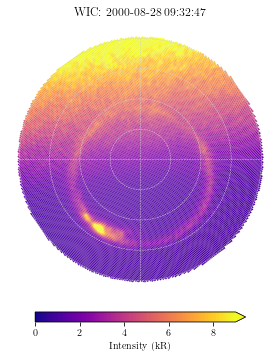

In [5]:
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = pp(ax)
fuv.showFUVimg(wic.isel(date=4),'imgR',pax=pax,crange=(0,9),cmap='plasma')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='max')
cbar.set_label('{} ({})'.format(wic['imgR'].attrs['long_name'],wic['imgR'].attrs['units']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=2)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

Time to remove the dayglow, using the offset-corrected image. Going retro, we also use the colormap from the IMAGE mission. The simplest method is described in the appendix in *Ohma et al.* (2018), but more advanced functional forms and the possibility to dampen the temporal terms in the fit are supported in the code. The value of the parameters used to make the dayglow model are stored as attributes in the dataset.

/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy.py:349: RuntimeWarning: invalid value encountered in log
  d = np.log(imgs[inImg].stack(z=('row','col')).values+1)
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy.py:357: RuntimeWarning: invalid value encountered in cos
  fraction = np.cos(np.deg2rad(sza))/np.cos(np.deg2rad(dza))


Building dayglow G matrix
Iteration: 0
Iteration: 1
Relative change model norm 0.009673479505769106
Iteration: 2
Relative change model norm 0.00323217980244801
Iteration: 3
Relative change model norm 0.0011438909393400936
Iteration: 4
Relative change model norm 0.0004735554718555971


/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy.py:440: RuntimeWarning: overflow encountered in exp
  imgs['dgmodel'] = (['date','row','col'],(np.exp(dm)).reshape((n_t,len(imgs.row),len(imgs.col))))
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy.py:478: RuntimeWarning: invalid value encountered in cos
  fraction = np.cos(np.deg2rad(sza))/np.cos(np.deg2rad(dza))
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/polplot/polplot.py:616: RuntimeWarning: invalid value encountered in cos
  return r*np.cos(a), r*np.sin(a)
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/polplot/polplot.py:616: RuntimeWarning: invalid value encountered in sin
  return r*np.cos(a), r*np.sin(a)


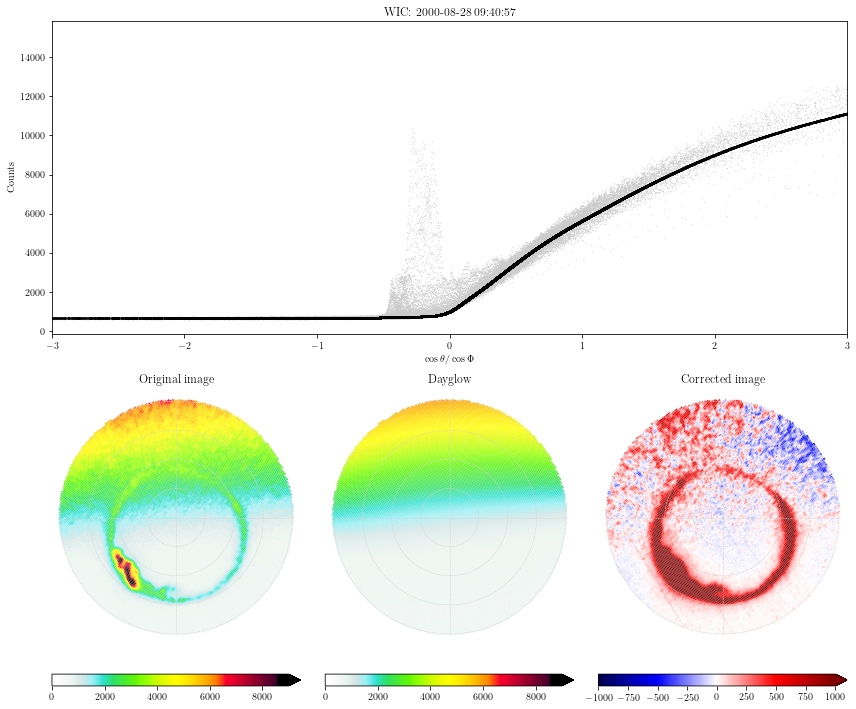

In [6]:
wic = fuv.makeFUVdayglowModel(wic,transform='log',tOrder=0)
fuv.showFUVdayglowModel(wic.isel(date=6),cmap=fuv.getIMAGEcmap())

Dayglow is subtracted, but the image is not perfect. We model the residual background using a spheric harmonics model

/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy.py:845: RuntimeWarning: invalid value encountered in remainder
  phi = np.deg2rad((glon - sslon[:,None] + 180) % 360 - 180)
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/utils/sh.py:166: RuntimeWarning: invalid value encountered in sin
  sinth = np.sin(d2r*theta)
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/utils/sh.py:167: RuntimeWarning: invalid value encountered in cos
  costh = np.cos(d2r*theta)


Building sh G matrix
Iteration: 0
Iteration: 1
Relative change model norm: 0.11494720455361544
Iteration: 2
Relative change model norm: 0.026618307649425927
Iteration: 3
Relative change model norm: 0.01971499178408701
Iteration: 4
Relative change model norm: 0.014076156957696434
Iteration: 5
Relative change model norm: 0.008996884808338716
Iteration: 6
Relative change model norm: 0.005423778090148024
Iteration: 7
Relative change model norm: 0.0031667172751875
Iteration: 8
Relative change model norm: 0.0018156352189618954
Iteration: 9
Relative change model norm: 0.0010303685861406738
Iteration: 10
Relative change model norm: 0.0005815331434058835


/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/polplot/polplot.py:616: RuntimeWarning: invalid value encountered in cos
  return r*np.cos(a), r*np.sin(a)
/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/polplot/polplot.py:616: RuntimeWarning: invalid value encountered in sin
  return r*np.cos(a), r*np.sin(a)


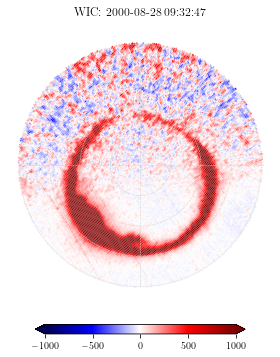

In [7]:
wic = fuv.makeFUVshModel(wic,4,4,order=0)

fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = pp(ax)
fuv.showFUVimg(wic.isel(date=6),'shimg',pax=pax,crange=(-1000,1000),cmap='seismic')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='both')

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=2)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
plt.tight_layout()



The images can also be plotted in an mlt-mlat projection. If there is any interest, this function can be expanded to also do mlon-mlat and glon-glat projections.

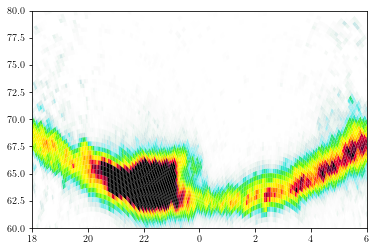

In [8]:
fuv.showFUVimgProjection(wic.isel(date=4),inImg='shimg',crange=(0,1500),cmap=fuv.getIMAGEcmap())

Currently, two approaches to identifying the open-closed boundary (ocb) are included. Both methods divide the image into 48 1-hr wide overlapping mlt sectors. 

Image: 0
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image: 8
Image: 9
Image: 10
Image: 11
Image: 12
Image: 13
Image: 14


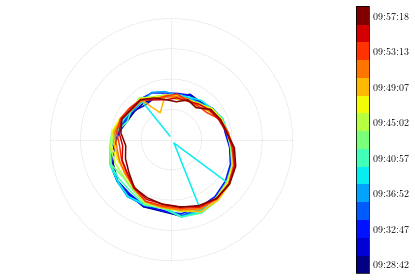

In [9]:
import numpy as np
b = fuv.findBoundaries(wic)
fuv.plotOCBtimeseries(b.sel(lim=1),'ocb')

Iteration: 0
Iteration: 1
Relative change model norm 0.0061971413449065805
Iteration: 2
Relative change model norm 0.008850962552456432
Iteration: 3
Relative change model norm 0.004996078366536521
Iteration: 4
Relative change model norm 0.0024222197989715462
Iteration: 5
Relative change model norm 0.0013794577369760544
Iteration: 6
Relative change model norm 0.0009629348294884132
Iteration: 0
Iteration: 1
Relative change model norm 0.02325338437216349
Iteration: 2
Relative change model norm 0.0019395010418478994
Iteration: 3
Relative change model norm 0.002109574151386311
Iteration: 4
Relative change model norm 0.0012560396601052292
Iteration: 5
Relative change model norm 0.0008459750717326238


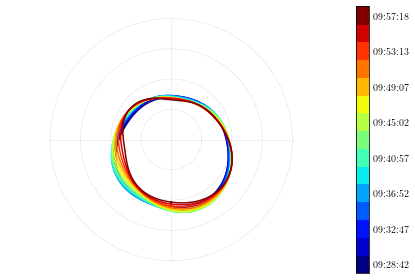

In [10]:
b2 = fuv.makeBoundaryModel(b)
fuv.plotOCBtimeseries(b2)

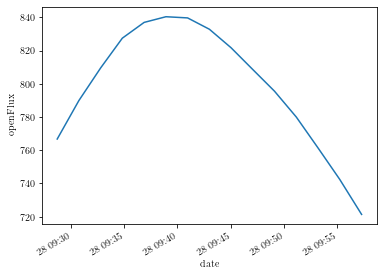

In [11]:
flux= fuv.calcFlux(b2)
flux['openFlux'].plot()

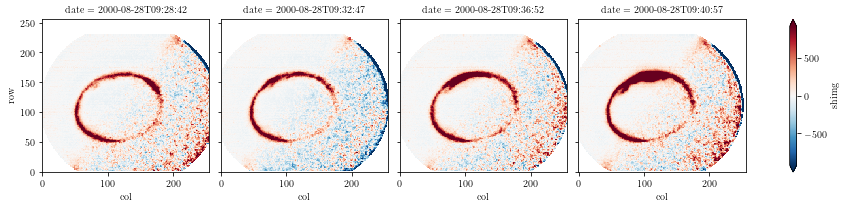

In [13]:
(wic.isel(date=slice(4,7))['shimg']).plot(x='col', y='row', col='date',robust=True)

In [16]:
wic['imgR'].attrs['long_name']

'Intensity'